In [42]:
import pandas as pd
import lzma
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from scipy.stats import t as tstudent

In [43]:
def fetch_results(horizon: int, method: str):
    files = []
    for file in glob.glob(f"results/inventory/{method}/horizon_{horizon}/*.csv"):
        files.append(file)
    return files

def compute_CE(mu, std, N: int, c = 0.95):
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    return c * std/ np.sqrt(N)

In [44]:
METHODS = ['empirical']#, 'gradient']
HORIZONS = [5, 10, 15, 20, 25]
epsilons = np.linspace(0, 1, 21)
scores_names = []
data = {}

for method in METHODS:
    data[method] = {}
    for horizon in HORIZONS:
        files = fetch_results(horizon, method)
        data[method][horizon] = {}
        for file_id, file in enumerate(files):
            data[method][horizon][file_id] = pd.read_csv('./' + file)


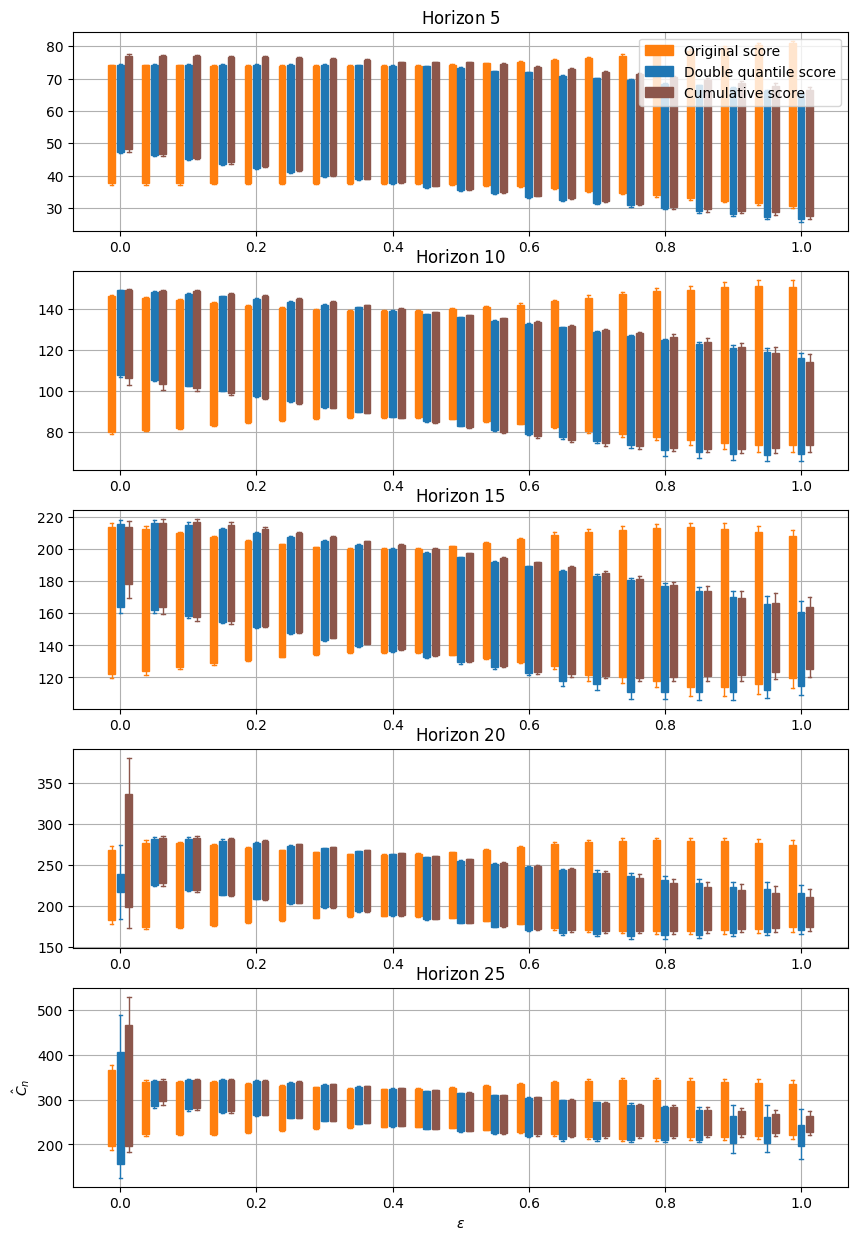

In [75]:

def compute_mean_std(key: str, method: str, horizon: int):
    mu = []
    std = []
    n = 0
    data_m_h = data[method][horizon]
    for id_run in data_m_h:
        n += 1
        mu.append(data_m_h[id_run][f'avg_{key}'].to_numpy())
        std.append(data_m_h[id_run][f'std_{key}'].to_numpy())
    
    mu = np.array(mu)
    std = np.array(std)
    return mu.mean(axis=0), mu.std(ddof=1,axis=0) + std.mean(axis=0), n

keys = {
    'Original score': {
        'lower': 'interval_target_lower',
        'upper': 'interval_target_upper',
        'color': 'tab:orange'
    },
    'Double quantile score': {
        'lower': 'interval_target_double_lower',
        'upper': 'interval_target_double_upper',
        'color': 'tab:blue'
    },
    'Cumulative score': {
        'lower': 'interval_target_cumul_lower',
        'upper': 'interval_target_cumul_upper',
        'color': 'tab:brown'
    }
    
}
     # if id > 0:
        #     plt.plot(epsilons, mu_lower_original)
        # else:
        #     plt.plot(epsilons, mu_lower_original, label = name)
        # plt.fill_between(
        #     epsilons,
        #     mu_lower_original - ce_lower_original,
        #     mu_lower_original + ce_lower_original, alpha=0.2)

fig, ax = plt.subplots(len(HORIZONS), figsize=(10,15))

bps = []
labels= []
for hid, horizon in enumerate(HORIZONS):
    for name_id, name in enumerate(keys):
        mu_lower_original, std_lower_original, n_lower_original = compute_mean_std(keys[name]['lower'], 'empirical', horizon)
        ce_lower_original = compute_CE(mu_lower_original, std_lower_original, n_lower_original)
        
        mu_upper_original, std_upper_original, n_upper_original = compute_mean_std(keys[name]['upper'], 'empirical', horizon)
        ce_upper_original = compute_CE(mu_upper_original, std_upper_original, n_upper_original)
    
        
        median = (mu_upper_original + mu_lower_original)/2
            
        boxes = [
            {
                'label' : name,
                'whislo': mu_lower_original[id] - ce_lower_original[id],    # Bottom whisker position
                'q1'    : mu_lower_original[id],    # First quartile (25th percentile)
                'med'   : median[id],    # Median         (50th percentile)
                'q3'    : mu_upper_original[id],    # Third quartile (75th percentile)
                'whishi': mu_upper_original[id] + ce_upper_original[id],    # Top whisker position
                'fliers': []        # Outliers
            }
            for id in range(len(epsilons))
        ]
        offset = -0.0125 + 0.0125 * name_id
        bp = ax[hid].bxp(boxes, epsilons + offset, widths=0.01, showfliers=False, patch_artist=True, manage_ticks=False, showmeans=False)
        
        if horizon == 5:
            bps.append(bp)
            labels.append(name)
        for element in ['boxes', 'whiskers', 'fliers', 'caps']:
            plt.setp(bp[element], color=keys[name]['color'])
            
        plt.setp(bp['medians'], linewidth=0)
        ax[hid].grid()
        ax[hid].set_title(f'Horizon ${horizon}$')
        
    #ax.set_xticks(epsilons)
    
ax[0].legend([bp["boxes"][0] for bp in bps], labels, loc='upper right')

plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$\hat C_n$')

plt.savefig('figures/inventory/confidence_intervals.pdf')
plt.show()

In [59]:
horizon_lengths = []
horizon_coverage = []
horizon_lengths_double = []
horizon_coverage_double = []
horizon_lengths_cumul = []
horizon_coverage_cumul = []
horizon_lengths_std = []
horizon_coverage_std = []
horizon_lengths_std_double = []
horizon_coverage_std_double = []
horizon_lengths_std_cumul = []
horizon_coverage_std_cumul = []
num_runs = []
#horizons = [5,10,15,20,25]

for method in METHODS:
    for horizon in HORIZONS:
        avg_length = []
        avg_length_double = []
        avg_length_cumul = []
        coverage = []
        coverage_double = []
        coverage_cumul = []
        files = fetch_results(horizon, method)
        for file_id, file in enumerate(files):

            avg_length = data[method][horizon][file_id]["avg_length"].to_numpy() if len(avg_length) == 0 else np.vstack((avg_length, data[method][horizon][file_id]["avg_length"].to_numpy()))
            avg_length_double = data[method][horizon][file_id]["avg_length_double"].to_numpy() if len(avg_length_double) == 0 else np.vstack((avg_length_double, data[method][horizon][file_id]["avg_length_double"].to_numpy()))
            avg_length_cumul = data[method][horizon][file_id]["avg_length_cumul"].to_numpy() if len(avg_length_cumul) == 0 else np.vstack((avg_length_cumul, data[method][horizon][file_id]["avg_length_cumul"].to_numpy()))

            coverage = data[method][horizon][file_id]["coverage"].to_numpy() if len(coverage) == 0 else np.vstack((coverage, data[method][horizon][file_id]["coverage"].to_numpy()))
            coverage_double = data[method][horizon][file_id]["coverage_double"].to_numpy() if len(coverage_double) == 0 else np.vstack((coverage_double, data[method][horizon][file_id]["coverage_double"].to_numpy()))
            coverage_cumul = data[method][horizon][file_id]["coverage_cumul"].to_numpy() if len(coverage_cumul) == 0 else np.vstack((coverage_cumul, data[method][horizon][file_id]["coverage_cumul"].to_numpy()))
        num_runs.append(len(files))
        horizon_lengths.append(np.mean(avg_length, 0))
        horizon_coverage.append(np.mean(coverage, 0))
        horizon_lengths_double.append(np.mean(avg_length_double, 0))
        horizon_coverage_double.append(np.mean(coverage_double, 0))
        horizon_lengths_cumul.append(np.mean(avg_length_cumul, 0))
        horizon_coverage_cumul.append(np.mean(coverage_cumul, 0))

        horizon_lengths_std.append(np.std(avg_length, 0))
        horizon_coverage_std.append(np.std(coverage, 0))
        horizon_lengths_std_double.append(np.std(avg_length_double, 0))
        horizon_coverage_std_double.append(np.std(coverage_double, 0))
        horizon_lengths_std_cumul.append(np.std(avg_length_cumul, 0))
        horizon_coverage_std_cumul.append(np.std(coverage_cumul, 0))

num_runs = np.array(num_runs)
horizon_lengths = np.array(horizon_lengths)
horizon_coverage = np.array(horizon_coverage)
horizon_lengths_double = np.array(horizon_lengths_double)
horizon_coverage_double = np.array(horizon_coverage_double)
horizon_lengths_cumul = np.array(horizon_lengths_cumul)
horizon_coverage_cumul = np.array(horizon_coverage_cumul)
horizon_lengths_std = np.array(horizon_lengths_std)
horizon_coverage_std = np.array(horizon_coverage_std)
horizon_lengths_std_double = np.array(horizon_lengths_std_double)
horizon_coverage_std_double = np.array(horizon_coverage_std_double)
horizon_lengths_std_cumul = np.array(horizon_lengths_std_cumul)
horizon_coverage_std_cumul = np.array(horizon_coverage_std_cumul)

In [61]:
num_runs

array([30, 25, 24, 26, 22])

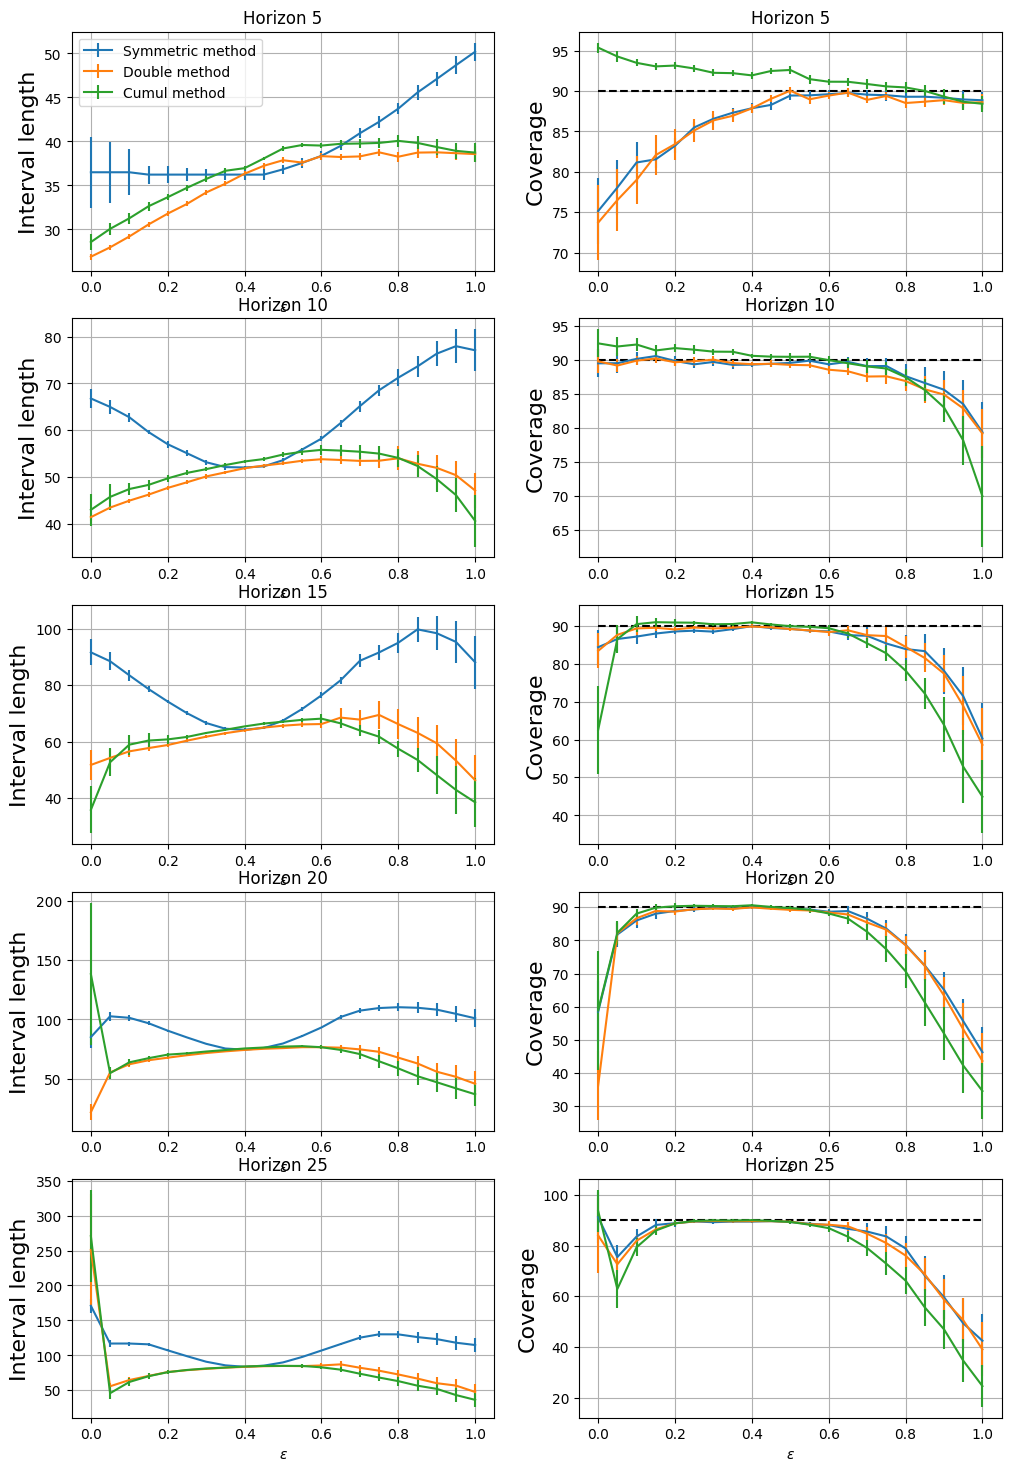

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(len(HORIZONS),2, figsize=(12, 18))


for i in range(len(HORIZONS)):
    ce = compute_CE(horizon_lengths[i], horizon_coverage_std[i], num_runs[i])
    line = ax[i,0].errorbar(epsilons, horizon_lengths[i], ce)
    if i == 0:
        line.set_label(f"Symmetric method")
    
    ce = compute_CE(horizon_lengths_double[i], horizon_lengths_std_double[i], num_runs[i])
    line = ax[i,0].errorbar(epsilons, horizon_lengths_double[i],ce)
    if i == 0:
        line.set_label(f"Double method")

    ce = compute_CE(horizon_lengths_cumul[i], horizon_lengths_std_cumul[i], num_runs[i])
    line = ax[i,0].errorbar(epsilons, horizon_lengths_cumul[i], ce)
    if i == 0:
        line.set_label(f"Cumul method")
    ax[i,0].set_xlabel('$\epsilon$')
    ax[i,0].set_ylabel('Interval length', fontsize=16)
    ax[i,0].grid()
    
    ax[i,1].plot(epsilons, np.ones(len(epsilons)) * 90, '--k')


    ce = compute_CE(horizon_coverage[i], horizon_coverage_std[i], num_runs[i])
    ax[i,1].errorbar(epsilons, horizon_coverage[i], ce)
    
    ce = compute_CE(horizon_coverage_double[i], horizon_coverage_std_double[i], num_runs[i])
    ax[i,1].errorbar(epsilons, horizon_coverage_double[i], ce)

    ce = compute_CE(horizon_coverage_cumul[i], horizon_coverage_std_cumul[i], num_runs[i])
    ax[i,1].errorbar(epsilons, horizon_coverage_cumul[i], ce)
    ax[i,1].set_xlabel('$\epsilon$')
    ax[i,1].set_ylabel('Coverage', fontsize=16)
    ax[i,1].grid()
    ax[i,0].set_title(f'Horizon {HORIZONS[i]}')
    ax[i,1].set_title(f'Horizon {HORIZONS[i]}')
ax[0,0].legend()
plt.savefig('figures/inventory/coverage_int_length.pdf')

array([[76.    , 83.2724, 95.    , 94.    , 96.    , 71.    , 41.    ,
         5.    ,  1.    ,  0.    ],
       [88.    , 91.254 , 90.    , 86.    , 84.    , 68.    , 42.    ,
         3.    ,  1.    ,  0.    ],
       [87.    , 93.    , 89.    , 79.    , 77.    , 52.    , 29.    ,
         2.    ,  1.    ,  0.    ],
       [87.    , 93.    , 88.    , 70.    , 72.    , 51.    , 22.    ,
         2.    ,  1.    ,  0.    ],
       [87.    , 93.    , 85.    , 67.    , 67.    , 41.    , 38.    ,
         0.    ,  1.    ,  0.    ]])

In [2]:
import numpy as np
from random_mdp import MDPEnv, MDPEnvDiscreteRew, MDPEnvBernoulliRew
from agent import QlearningAgent
from greedy_policy import EpsilonGreedyPolicy, TableBasedPolicy, MixedPolicy
from utils import get_data, collect_exp, train_predictor, train_behaviour_policy, value_iteration, save_important_dictionary
from networks import MLP, WeightsMLP, WeightsTransformerMLP
from dynamics_model import DynamicsModel, DiscreteRewardDynamicsModel, ContinuousRewardDynamicsModel
import torch
from collections import defaultdict
import pickle
import random
from weights import WeightsEstimator, ExactWeightsEstimator
from conformal_set import ConformalSet
from custom_environments.inventory import Inventory
from multiprocessing import freeze_support
from logger import Logger
import os

important_stuff = None
with open("horizon/horizon_25/data/useful_saves_run_1_0.5.pkl", "rb") as f2:
    important_stuff = pickle.load(f2)

In [5]:
weights_estimator = important_stuff["Weights_estimator"]
exact_weights_estimator = important_stuff["Exact_weights_estimator"]
conformal_set = important_stuff["Conformal_set"]
weights = important_stuff["weights"]
scores = important_stuff["scores"]
weight_network = important_stuff["weight_network"]
env = important_stuff["env"]
pi_target = conformal_set.pi_star
pi_b = conformal_set.behaviour_policy

In [6]:
for s in range(env.ns):
    
    test_points = collect_exp(env, 2000, 25, pi_target, None, s)
    y_vals = [point[1] for point in test_points]
    print(np.mean(y_vals))
    intervals, lower_quantile, upper_quantile, quantiles = conformal_set.build_set(test_points, weights, scores, 1, weight_network, True)
    
    
    
    

[212, 271, 347, 240, 283, 274, 271, 312, 308, 323, 254, 293, 272, 292, 253, 293, 249, 210, 262, 268, 295, 289, 276, 294, 281, 275, 217, 293, 264, 311, 267, 285, 259, 310, 267, 247, 273, 301, 311, 245, 267, 248, 296, 261, 303, 283, 255, 303, 287, 290, 289, 284, 274, 261, 265, 263, 297, 253, 258, 273, 255, 224, 279, 237, 291, 278, 282, 329, 321, 302, 310, 257, 228, 267, 226, 265, 274, 297, 271, 279, 254, 254, 273, 301, 269, 267, 251, 267, 272, 310, 321, 336, 297, 251, 301, 302, 298, 279, 286, 251, 261, 207, 262, 269, 282, 299, 248, 239, 285, 231, 277, 277, 276, 283, 257, 273, 268, 301, 253, 309, 218, 236, 248, 258, 264, 277, 267, 223, 248, 301, 300, 283, 230, 337, 285, 248, 286, 285, 277, 276, 284, 287, 301, 254, 267, 245, 295, 267, 312, 271, 267, 202, 260, 263, 307, 270, 297, 292, 254, 281, 264, 308, 247, 240, 245, 268, 353, 265, 262, 272, 317, 257, 272, 318, 252, 275, 300, 299, 245, 297, 249, 251, 285, 265, 297, 225, 325, 213, 301, 295, 244, 264, 296, 259, 264, 293, 295, 257, 243, 275,

KeyboardInterrupt: 